In [44]:
from utils.image_treatment import preprocess_image
import matplotlib.pyplot as plt
import numpy as np
import pyrtools as pt
from tqdm import tqdm

In [2]:
image_path1 = 'data/Red.jpg'
image_path2 = 'data/Water.jpg'

In [4]:
image1 = preprocess_image(image_path1, new_size = (200,200))
image2 = preprocess_image(image_path2, new_size = (200,200))
textures = [image1, image2]

In [ ]:
def dist(x1,x2,y1,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def compute_optimal_transport(X, Y, iterations = 100, projections = 1, return_asg = False):
    """
    Compute the optimal transport between two point clouds.

    Parameters:
    - X (ndarray): Source point cloud
    - Y (ndarray): Target point cloud
    - iterations (int): Number of iterations for the optimization process
    - projections (int): Number of random projections used in each iteration
    - return_asg (bool): If True, return the sorted indices of the final point cloud

    Returns:
    - ndarray: Optimal transport between the source and target point clouds
    - (Optional) ndarray: Sorted indices of the final point cloud along with the source and target point clouds
    """
    
    Z = X.copy()
    N = X.shape[0]
    D = X.shape[-1]
    lr = 1
    if(projections == -1):
        projections = D
    
    for i in range(iterations):
        grad = 0
        for p in range(projections):
            theta = np.random.uniform(-1, 1, D)
            theta /= np.linalg.norm(theta)
            proj_z = Z @ theta
            proj_y = Y @ theta
            sz = np.argsort(proj_z)
            sy = np.argsort(proj_y)
            grad += proj_z[sz] - proj_y[sy]
        grad = grad.reshape(-1, 1) / projections
        grad = grad @ theta.reshape(-1, 1).T
        Z[sz] -= lr * grad
        lr *= 0.999
    if(return_asg):
        return Z, sy, sz
    return Z

def compute_optimal_transport_barycenter(X_ini, lambdas, point_clouds, iterations = 1000, projections = 1, return_asg = False):
    """
    Compute the optimal transport barycenter of multiple point clouds.

    Parameters:
    - X_ini (ndarray): Initial point cloud for the barycenter computation
    - lambdas (list): List of weights corresponding to the contribution of each point cloud
    - point_clouds (list): List of point clouds (ndarrays) to be averaged
    - iterations (int): Number of iterations for the optimization process
    - projections (int): Number of random projections used in each iteration
    - return_asg (bool): If True, return the sorted indices of the final point cloud

    Returns:
    - ndarray: Optimal transport barycenter of the input point clouds
    - (Optional) ndarray: Sorted indices of the final point cloud along with the input point clouds
    """
    
    assert 1 - 1e-5 < sum(lambdas) < 1 + 1e-5, 'the sum of the weights must be 1'
    Z = X_ini.copy()
    N = X_ini.shape[0]
    D = X_ini.shape[-1]
    lr = 1
    if(projections == -1):
        projections = D
    
    for i in range(iterations):
        grad = np.zeros((N, D))
        for p in range(projections):
            theta = np.random.uniform(-1, 1, D)
            theta /= np.linalg.norm(theta)
            for lmb in range(len(lambdas)):
                grad_tmp = 0
                proj_z = Z @ theta
                proj_y = point_clouds[lmb] @ theta
                sz = np.argsort(proj_z)
                sy = np.argsort(proj_y)
                grad_tmp += lambdas[lmb] * (proj_z[sz] - proj_y[sy])
                grad_tmp = grad_tmp.reshape(-1, 1)
                grad += grad_tmp @ theta.reshape(-1, 1).T
        Z[sz] -= lr * grad / projections
        lr *= 0.999
    if(return_asg):
        return Z, sy, sz
    return Z

def compute_optimal_assignment(X, Y):

    """
    Compute the optimal assignment between two sets of points by sorting them.

    Parameters:
    - X (ndarray): Input matrix representing the source set of points
    - Y (ndarray): Input matrix representing the target set of points

    Returns:
    - ndarray: The optimal assignment from X to Y
    """
    
    Z = np.zeros_like(X)
    for i in range(X.shape[-1]):
        sz = X.reshape(-1,X.shape[-1])[:, i].argsort()
        sy = Y.reshape(-1,X.shape[-1])[:, i].argsort()
        Z[sz, i] = Y.reshape(-1, X.shape[-1])[sy, i]
    return Z

def build_pyramid(image, num_scales=4, num_orientations=4):
    """
    Compute wavelets coefficients (highpass, bandpass, low-residuals) for the 3 channels (R,G,B) of an image
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - wavelets_coeffs: Dictionary of coefficients organized by channel (R,G,B) and then by bandpass (highpass, bandpass -scale and orientation- and low residual).
    """
    pyramid_r = pt.pyramids.SteerablePyramidFreq(image[:,:,0], height=num_scales, order=num_orientations-1).pyr_coeffs
    pyramid_g = pt.pyramids.SteerablePyramidFreq(image[:,:,1], height=num_scales, order=num_orientations-1).pyr_coeffs
    pyramid_b = pt.pyramids.SteerablePyramidFreq(image[:,:,2], height=num_scales, order=num_orientations-1).pyr_coeffs
    
    combined_dict = {}
    # Parcourir les clés (identiques pour les trois dictionnaires)
    for key in pyramid_r.keys():
        # Empiler les matrices R, G, B le long d'une nouvelle dimension pour obtenir un array (n, n, 3)
        combined_dict[key] = np.stack((pyramid_r[key], pyramid_g[key], pyramid_b[key]), axis=-1)

    return(combined_dict)


In [46]:
#texture mixing 

#parameters 
num_scales = 4
num_orientations = 4
rho = [1/2,1/2]

#initialization of a noise
size = textures[0].shape[0]
noise = np.random.randn(size, size, 3)

#compute pyramid coefficients for each texture
pyramids = []
for texture in textures:
    pyramids.append(build_pyramid(texture, num_scales=num_scales, num_orientations=num_orientations)) #returns a dico with pyramid for R,G,B
#compute pyramid coefficients for white noise
pyramid_wn = build_pyramid(noise, num_scales=num_scales, num_orientations=num_orientations)

#compute barycenter of each pyramid coefficient, in 3D
pyramid_barycenter = {}
for key in tqdm(pyramid_wn.keys()):
    size = pyramid_wn[key].shape[0]
    pyramid_barycenter[key] = compute_optimal_transport_barycenter(pyramid_wn[key].reshape(-1,3), rho, [x[key].reshape(-1,3) for x in pyramids])
    pyramid_barycenter[key] = pyramid_barycenter[key].reshape(size, size, 3)


100%|██████████| 18/18 [03:02<00:00, 10.14s/it]


In [54]:
for key in pyramid_wn.keys():
    size = pyramid_wn[key].shape[0]
    projection = compute_optimal_assignment(pyramid_wn[key].reshape(-1, 3), pyramid_barycenter[key].reshape(-1, 3)).reshape(size, size, 3)
    pyramid_wn[key] = projection
    

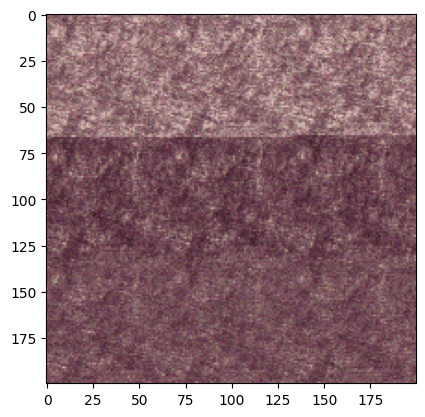

In [61]:
#ce que j'ai a ce niveau : les barycentres en couleurs pour chaque coefficient
#mtn je veux reconstruire une image a partir des coefficients de la pyramide
#je separe les R, G, et B et je construis une image a partir de chaque coeff

pyramid_barycenter_r = {}
pyramid_barycenter_g = {}
pyramid_barycenter_b = {}
for key in pyramid_barycenter.keys(): #pour chaque coefficient (qui est pour l'instant en RGB)
    #il faut extraire les coefficients pour R, G et B
    pyramid_barycenter_r[key] = pyramid_barycenter[key][:,:,0]
    pyramid_barycenter_g[key] = pyramid_barycenter[key][:,:,1]
    pyramid_barycenter_b[key] = pyramid_barycenter[key][:,:,2]

#puis on reconstruit les images a partir de chaque pyramide R, G et B
size = textures[0].shape[0]
noise = np.random.randn(size, size)
noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise, height=num_scales, order=num_orientations-1)

noisy_pyr.pyr_coeffs = pyramid_barycenter_r
reconstructed_pyr_r = noisy_pyr.recon_pyr()
noisy_pyr.pyr_coeffs = pyramid_barycenter_g
reconstructed_pyr_g = noisy_pyr.recon_pyr()
noisy_pyr.pyr_coeffs = pyramid_barycenter_b
reconstructed_pyr_b = noisy_pyr.recon_pyr()

reconstructed_pyr = np.stack([reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b])


size = textures[0].shape[0]
noise = np.random.randn(size, size, 3)
rgb_barycenter = compute_optimal_transport_barycenter(noise.reshape(-1, 3), rho, [x.reshape(-1, 3) for x in textures], iterations=100).reshape(size, size, 3)

final_texture = compute_optimal_transport(reconstructed_pyr.reshape(-1,3), rgb_barycenter.reshape(-1, 3),iterations=50).reshape(size, size, 3)

plt.imshow(final_texture.astype(int))
